In [1]:
project_dir = "/Users/joannarownicka/software/vad"
os.chdir(project_dir)

In [2]:
import numpy as np
import os
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import torch

from lhotse.cut import CutSet
from lhotse.dataset.sampling import SingleCutSampler, BucketingSampler
from lhotse.dataset.vad import VadDataset

from torch.utils.data import DataLoader

from models.dnn import DNN
from inference.postprocess import smooth_predictions
from models.accuracy import compute_acc_without_pad

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
root_dir = Path('evaluation/data')
corpus_dir = root_dir / 'vad_data/'
output_dir = root_dir / 'vad_data_nb/'
model_path = Path('storage/models/dnn_ce_fbank80_ignoreindex_lr2/checkpoint_14.pth')

cuts_eval = CutSet.from_json(output_dir / 'cuts_80_eval.json.gz')
vad_dataset = VadDataset()
eval_sampler = SingleCutSampler(cuts_eval, shuffle=False, max_duration=300)
eval_dloader = DataLoader(vad_dataset, sampler=eval_sampler, batch_size=None)

In [4]:
pred_list = []
gold_list = []

cut_ids = next(iter(eval_sampler))
sample = vad_dataset[cut_ids]
input_size = sample['inputs'][0].shape[1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DNN(input_size=input_size, hidden_size=256, num_classes=2)
model.load_state_dict(torch.load(model_path)['state_dict'])

model.eval()
with torch.no_grad():
    for data in eval_dloader:
        
        inputs_eval = data["inputs"].reshape(-1,input_size)
        targets_eval = data["is_voice"].reshape(-1,1).view(-1)

        out = model(inputs_eval.to(device))
        model_acc, predictions, labels = compute_acc_without_pad(
            out, targets_eval.unsqueeze(1).to(device))

        pred_list.extend(predictions)
        gold_list.extend(labels)

In [5]:
smoothed_pred_list = smooth_predictions(
                pred_list, \
                smooth_num_frames=3, \
                hangover=True, \
                min_speech_frames=10)

In [6]:
print(confusion_matrix(gold_list, smoothed_pred_list))
print(classification_report(gold_list, smoothed_pred_list))

[[21308  3358]
 [ 4963 90056]]
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84     24666
         1.0       0.96      0.95      0.96     95019

    accuracy                           0.93    119685
   macro avg       0.89      0.91      0.90    119685
weighted avg       0.93      0.93      0.93    119685



In [7]:
def visualise(
    l: List, num_frames: int, title: str):
    label_height = 10
    vad_label = np.stack([(l[:num_frames]) \
        for i in range(label_height)]).reshape(label_height, num_frames)
    plt.matshow(vad_label)
    plt.title(title)

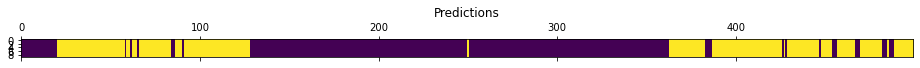

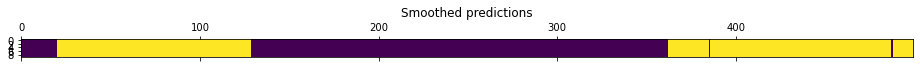

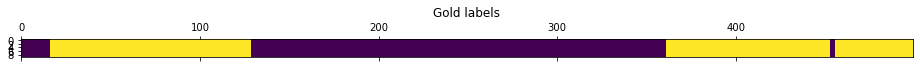

In [8]:
num_frames = 500
assert num_frames <= len(pred_list)

visualise(pred_list, num_frames=num_frames, title="Predictions")
visualise(smoothed_pred_list, num_frames=num_frames, title="Smoothed predictions")
visualise(gold_list, num_frames=num_frames, title="Gold labels")